<a href="https://colab.research.google.com/github/AEmanuelli/M-moire_Anis_Alexis/blob/main/TME_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Pour éviter les densités nulles, on ajoute une très petite valeur (ex: 10^-10) à chaque vraisemblance avant de passer au logarithme, ce qui permet d'éviter les erreurs lors du calcul et de minimiser l'impact de cette valeur sur la log-vraisemblance.

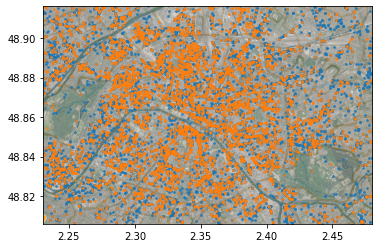

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd


POI_FILENAME = "/content/poi-paris.pkl"
parismap = mpimg.imread('/content/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]


class Density(object):
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data):
        log_likelihood = np.log(self.predict(data) + 1e-10)
        return np.sum(log_likelihood)

class Histogramme(Density):
    def __init__(self, steps=10):
        Density.__init__(self)
        self.steps = steps

    def fit(self, x):
        hist, self.edges = np.histogramdd(x, bins=self.steps)
        self.hist = hist / np.sum(hist)

    def predict(self, x):
        bin_indices = np.apply_along_axis(self.to_bin, 1, x)
        return self.hist[bin_indices[:, 0], bin_indices[:, 1]]

    def to_bin(self, x):
        bin_indices = [np.digitize(x[i], self.edges[i][:-1]) for i in range(x.shape[0])]
        return np.array(bin_indices) - 1


class KernelDensity(Density):
    def __init__(self, kernel=None, sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, x):
        self.x = x

    def predict(self, data):
        n = self.x.shape[0]
        density = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            dist = np.linalg.norm(self.x - data[i], axis=1)
            density[i] = np.sum(self.kernel(dist / self.sigma)) / n
        return density


def get_density2D(f,data,steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

def show_density(f, data, steps=100, log=False):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note
    

plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.

poi_types = ["restaurant", "bar"]
for poi_type in poi_types:
    geo_mat, notes = load_poi(poi_type)
    plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)


# Affiche la carte de Paris
show_img()

In [ ]:
geo_mat, notes = load_poi("restaurant")

hist = Histogramme(100)  # créer un estimateur d'histogramme avec un pas de 100
hist.fit(geo_mat)
hist.predict(geo_mat)  # calculer l'histogramme

arr, x, y = get_density2D(hist, geo_mat, 100)
print(np.sum(arr))

1.0


1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0


<Figure size 432x288 with 0 Axes>

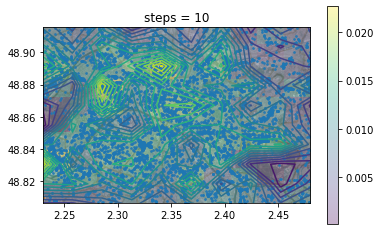

<Figure size 432x288 with 0 Axes>

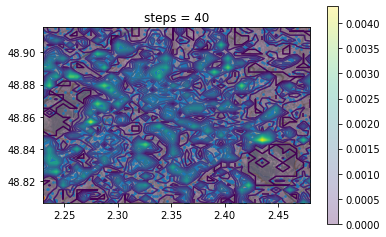

<Figure size 432x288 with 0 Axes>

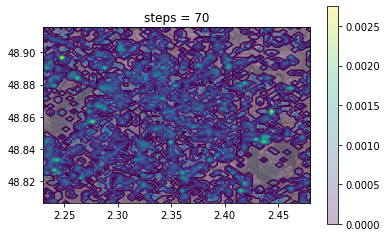

<Figure size 432x288 with 0 Axes>

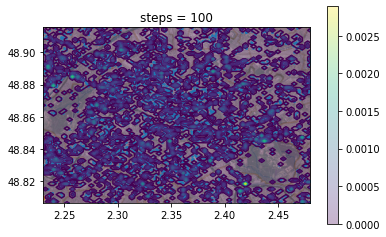

<Figure size 432x288 with 0 Axes>

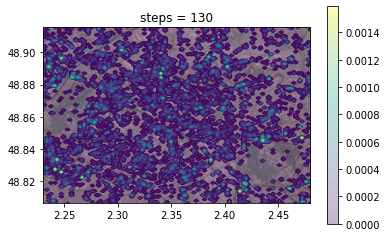

<Figure size 432x288 with 0 Axes>

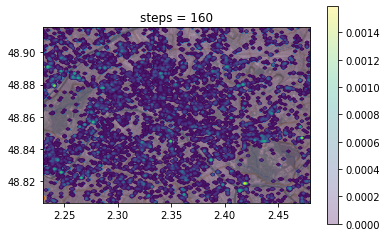

<Figure size 432x288 with 0 Axes>

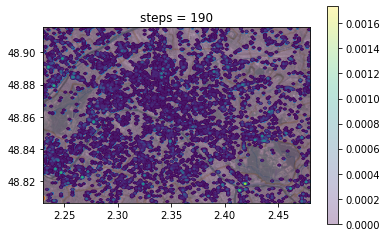

<Figure size 432x288 with 0 Axes>

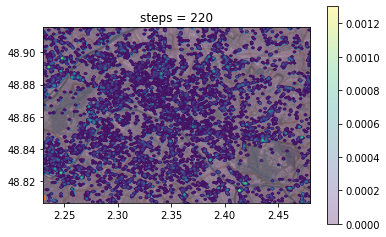

In [ ]:
for steps in range(10, 221, 30):
    plt.figure()
    hist = Histogramme(steps)
    hist.fit(geo_mat)
    show_density(hist, geo_mat, steps = steps)
    arr, x, y = get_density2D(hist, geo_mat, steps)
    print(np.sum(arr))
    plt.title("steps = {}".format(steps))

plt.show()

Pour les valeurs inférieures, la discrétisation est trop grossière, la densité semble trop "pixélisée" et ne reflète pas de manière précise la distribution des données. D'un autre côté, si la discrétisation est trop fine (steps = 200), cela conduit à des fluctuations excessives de la densité qui ne reflètent pas vraiment la distribution sous-jacente des données.
La meilleure discrétisation semble se trouver un peu en dessous de 100 pour moi, puisque l'on a alors des bins qui contiennnt suffisamment de données, mais qui ne sont pas trop gros et qui permettent don cd edécrre le jeu de données correctement

In [ ]:
geo_mat, notes = load_poi("restaurant")

# Diviser les données en ensembles d'apprentissage et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=42)


for steps in range(10, 220, 30): 
    # Entraîner un modèle Histogramme sur l'ensemble d'apprentissage
    h = Histogramme(steps)
    h.fit(X_train)


    # Évaluer la performance sur l'ensemble d'apprentissage et de test
    print("Score en apprentissage :", h.score(X_train))
    print("Score en test :", h.score(X_test))

Score en apprentissage : -24658.929759208673
Score en test : -6238.272562213544
Score en apprentissage : -37564.5941745188
Score en test : -10770.709186863405
Score en apprentissage : -41296.74391759132
Score en test : -14227.463058313842
Score en apprentissage : -43066.90244003787
Score en test : -17171.919191795954
Score en apprentissage : -44142.8853860807
Score en test : -19546.466730906122
Score en apprentissage : -44833.92176914017
Score en test : -21589.902019382727
Score en apprentissage : -45261.5799585394
Score en test : -22799.439269651586


In [ ]:
import numpy as np

class Nadaraya:
    def __init__(self, kernel='gaussian', bandwidth=1.0):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            weights = self.kernel_func(x)
            y_pred.append(np.sum(weights * self.y) / np.sum(weights))
        return np.array(y_pred)

    def kernel_func(self, x):
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * ((self.X - x) / self.bandwidth) ** 2)
        elif self.kernel == 'epanechnikov':
            u = abs((self.X - x) / self.bandwidth)
            return 3 / 4 * (1 - u ** 2) * (u < 1)
        elif self.kernel == 'uniform':
            u = abs((self.X - x) / self.bandwidth)
            return 0.5 * (u < 1)
        else:
            raise ValueError("Invalid kernel type. Available kernels are 'gaussian', 'epanechnikov', and 'uniform'.")


Pour vérifier que l'estimateur f est correct, il doit respecter les propriétés suivantes :

l'estimation doit être positive ou nulle partout sur la grille
l'intégrale de l'estimation sur toute la grille doit être égale à 1 (normalisation)
Pour afficher les densités obtenues pour différentes valeurs de pas de discrétisation, on peut utiliser la fonction show_density(f,data,steps,log), où f est l'estimateur, data est l'échantillon de données, steps est le nombre de pas de discrétisation et log est un booléen indiquant si l'échelle doit être logarithmique ou linéaire.
